# Pyspark TensorFlow Inference

## Image classification
Based on: https://www.tensorflow.org/tutorials/keras/save_and_load

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import tensorflow as tf

from tensorflow import keras

print(tf.version.VERSION)

### Load and preprocess dataset

In [ ]:
# load dataset as numpy arrays
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape, test_images.shape

In [ ]:
# flatten and normalize
train_images = train_images.reshape(-1, 784) / 255.0
test_images = test_images.reshape(-1, 784) / 255.0

In [ ]:
train_images.shape, test_images.shape

### Define a model

In [ ]:
# Define a simple sequential model
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Dense(512, activation='relu', input_shape=(784,)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=[tf.metrics.SparseCategoricalAccuracy()])

    return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

### Train model

In [ ]:
model.fit(train_images, 
          train_labels,  
          epochs=5,
          validation_data=(test_images, test_labels))

In [ ]:
test_img = test_images[:1]
model.predict(test_img)

In [ ]:
plt.figure()
plt.imshow(test_img.reshape(28,28))
plt.show()

### Save Model

In [ ]:
subprocess.call("rm -rf mnist_model".split())

In [ ]:
model.save('mnist_model')

### Inspect saved model

In [ ]:
subprocess.call("tree mnist_model".split())

In [ ]:
subprocess.call("saved_model_cli show --dir mnist_model --tag_set serve --signature_def serving_default".split())

### Load model

In [ ]:
new_model = tf.keras.models.load_model('mnist_model')
new_model.summary()

In [ ]:
new_model.inputs

### Predict

In [ ]:
new_model.predict(test_images[:1])

## PySpark

In [ ]:
import pandas as pd

# from pyspark.sql.functions import col, pandas_udf, PandasUDFType
# from pyspark.sql.types import *

### Convert numpy array to Spark DataFrame (via Pandas DataFrame)

In [ ]:
# numpy array to pandas DataFrame
test_pdf = pd.DataFrame(test_images)
test_pdf.shape

In [ ]:
%%time
# 784 columns of float
df = spark.createDataFrame(test_pdf)

In [ ]:
%%time
# 1 column of array<float>
test_pdf['data'] = test_pdf.values.tolist()
pdf = test_pdf[['data']]
pdf.shape

In [ ]:
%%time
df = spark.createDataFrame(pdf).repartition(10)

### Save the test dataset as parquet files

In [ ]:
df.write.mode("overwrite").parquet("mnist_test")

### Check arrow memory configuration

In [ ]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty" 

## Inference using Spark ML Model
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
import sparkext

In [ ]:
df = spark.read.parquet("mnist_test")

In [ ]:
model = sparkext.tensorflow.Model("mnist_model") \
            .setInputCol("data") \
            .setOutputCol("preds")

In [ ]:
predictions = model.transform(df)

In [ ]:
predictions.write.mode("overwrite").parquet("mnist_predictions")

### Check predictions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
%%time
preds = predictions.collect()

In [ ]:
preds[0].preds

In [ ]:
img = preds[0].data
img = np.array(img).reshape(28,28)

In [ ]:
plt.figure()
plt.imshow(img)
plt.show()

## Inference using Spark DL UDF
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
from pyspark.sql.functions import col

In [ ]:
df = spark.read.parquet("mnist_test")

In [ ]:
df.schema

In [ ]:
from sparkext.tensorflow import model_udf

In [ ]:
mnist = model_udf("mnist_model", batch_size=500)

In [ ]:
%%time
preds = df.withColumn("preds", mnist(col("data"))).collect()

## Inference using Triton UDF
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [ ]:
from pyspark.sql.functions import col

In [ ]:
df = spark.read.parquet("mnist_test")

In [ ]:
df.schema

In [ ]:
from sparkext.triton.udf import model_udf

In [ ]:
mnist = model_udf("localhost:8001", "mnist_model", batch_size=4)

In [ ]:
%%time
preds = df.withColumn("preds", mnist(col("data"))).collect()

### Check predictions

In [ ]:
preds[0].preds

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img = preds[0].data
img = np.array(img).reshape(28,28)

In [ ]:
plt.figure()
plt.imshow(img)
plt.show()

## Inference using Spark DL API

### 1 column of 784 float

In [1]:
import numpy as np

from pyspark.ml.udf import model_udf
from pyspark.sql.functions import struct
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [2]:
df = spark.read.parquet("mnist_test")
len(df.columns)

1

In [3]:
def model_fn():
    import tensorflow as tf
    model = tf.keras.models.load_model('/home/leey/devpub/leewyang/sparkext/examples/tensorflow/mnist_model')
    def predict(inputs: Union[np.array, Dict[str, np.array]]) -> Union[np.array, Dict[str, np.array]]:
        if type(inputs) is Dict:
            raise ValueError("This model only accepts a single numpy array as input")
        return model.predict(inputs)
        
    return predict

In [4]:
mnist = model_udf(model_fn, 
                  input_shapes=[[-1,784]], 
                  return_type=ArrayType(FloatType()), 
                  batch_size=100)

In [5]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

,data,preds
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-13.510869026184082, 8.844907760620117, -5.57..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.395193099975586, -2.227229595184326, -1.91..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-7.201132297515869, -8.855822563171387, -5.55..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-19.466154098510742, -13.986742973327637, -6...."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.774714469909668, -7.841520309448242, 12.59..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-5.256966590881348, -4.173648834228516, -12.7..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-13.054927825927734, -4.136531829833984, 1.47..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.751765251159668, -15.415200233459473, -5.88..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-8.122913360595703, -25.47602081298828, -5.66..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-9.354874610900879, -12.668562889099121, -3.3..."


### Check predictions

In [6]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.data

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
img = np.array(img).reshape(28,28)

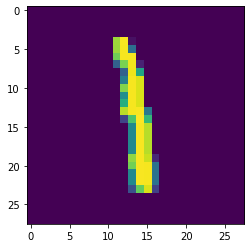

In [9]:
plt.figure()
plt.imshow(img)
plt.show()

In [10]:
predictions

[-13.510869026184082,
 8.844907760620117,
 -5.576374053955078,
 -0.12444938719272614,
 -2.520883083343506,
 -5.890664577484131,
 -5.495355606079102,
 -4.307830810546875,
 -1.2591326236724854,
 -8.233722686767578]

### 784 columns of float

In [11]:
df = spark.read.parquet("mnist_784")
len(df.columns)

784

In [12]:
preds = df.withColumn("preds", mnist(struct(df.columns))).limit(10).toPandas()
preds

22/08/23 14:05:26 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,preds
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-6.359180450439453, -5.758774757385254, -0.11..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-8.537405014038086, -0.48380306363105774, 17...."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-9.81694507598877, 7.71329402923584, -5.32088..."
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[10.783159255981445, -11.34924602508545, -2.29..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-4.9171833992004395, -13.104434967041016, -5...."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-10.542353630065918, 10.109085083007812, -9.4..."
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-12.700042724609375, -12.482470512390137, -10..."
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-13.782483100891113, -4.972370147705078, 0.04..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-17.031259536743164, -17.00119972229004, -4.6..."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[-14.641603469848633, -12.000832557678223, -12..."


### Check prediction

In [13]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [15]:
img = np.array(img).reshape(28,28)

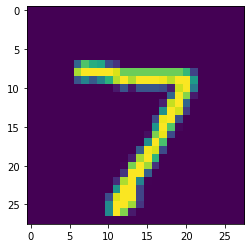

In [16]:
plt.figure()
plt.imshow(img)
plt.show()

In [17]:
predictions

[-6.359180450439453,
 -5.758774757385254,
 -0.1152595579624176,
 1.758821964263916,
 -16.298961639404297,
 -8.045355796813965,
 -18.80864143371582,
 11.975873947143555,
 -3.7541236877441406,
 -2.6068503856658936]

### Using Triton Server
Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [18]:
from pyspark.sql.functions import col, struct
from pyspark.sql.types import ArrayType, FloatType

In [19]:
df = spark.read.parquet("mnist_test")

In [20]:
df.schema

StructType([StructField('data', ArrayType(DoubleType(), True), True)])

In [21]:
from pyspark.ml.udf import model_udf

In [22]:
def model_fn():
    import numpy as np
    import tritonclient.grpc as grpcclient
    client = grpcclient.InferenceServerClient("localhost:8001")
    def predict(inputs):
        request = [grpcclient.InferInput("dense_input", inputs.shape, "FP32")]
        request[0].set_data_from_numpy(inputs.astype(np.float32))
        response = client.infer("mnist_model", inputs=request)
        return response.as_numpy("dense_1")
    return predict

In [23]:
mnist = model_udf(model_fn, 
                  input_shapes=[[-1,784]], 
                  return_type=ArrayType(FloatType()), 
                  batch_size=4)

In [24]:
%%time
preds = df.withColumn("preds", mnist(struct("data"))).collect()

CPU times: user 435 ms, sys: 156 ms, total: 591 ms
Wall time: 5.33 s


### Check predictions

In [25]:
preds[0].preds

[-15.636049270629883,
 7.199626445770264,
 -3.781431198120117,
 -0.8210459351539612,
 -2.818504571914673,
 -6.400110244750977,
 -8.396867752075195,
 -3.6723453998565674,
 -1.225862979888916,
 -6.030755043029785]

In [26]:
import matplotlib.pyplot as plt
import numpy as np

In [27]:
img = preds[0].data
img = np.array(img).reshape(28,28)

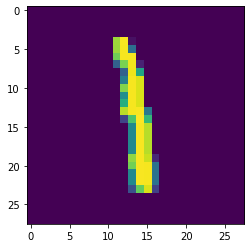

In [28]:
plt.figure()
plt.imshow(img)
plt.show()

### model_fn kwargs

In [32]:
def model_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    client = grpcclient.InferenceServerClient(triton_uri)
    model_metadata = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if inputs is dict:
        request = [grpcclient.InferInput("dense_input", inputs.shape, "FP32")]
        request[0].set_data_from_numpy(inputs.astype(np.float32))
        response = client.infer(model_name, inputs=request)
        return response.as_numpy("dense_1")
    return predict

In [55]:
mnist = model_udf(model_fn, 
                  input_shapes=[[-1,784]], 
                  return_type=ArrayType(FloatType()), 
                  batch_size=4,
                  triton_uri="localhost:8001",
                  model_name="mnist_model")

In [56]:
%%time
preds = df.withColumn("preds", mnist(struct("data"))).collect()

CPU times: user 656 ms, sys: 79.5 ms, total: 736 ms
Wall time: 3.3 s


### Generic Triton function

In [77]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool8),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name].astype(np_types[i.datatype]))
        
        response = client.infer(model_name, inputs=request)
        return response.as_numpy(model_meta.outputs[0].name)     # TODO: multiple outputs
        
    return predict

In [78]:
predict = model_udf(triton_fn, 
                    input_shapes=[[-1,784]], 
                    return_type=ArrayType(FloatType()), 
                    batch_size=4,
                    triton_uri="localhost:8001",
                    model_name="mnist_model")

In [79]:
%%time
preds = df.withColumn("preds", predict(struct("data"))).collect()

CPU times: user 678 ms, sys: 104 ms, total: 781 ms
Wall time: 2.74 s
